# Visualization of results from ABSA pre-trained Deberta model from HuggingFace

## Load the required libraries

In [1]:
import pandas as pd
import plotly.express as px
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

## Load the data set

In [2]:
# load the final result data set from deberta model
deberta_viz_df = pd.read_csv('deberta_aspect_score_sentiment_with_owner_provided_info_results_final.csv')

In [3]:
# show the first row
deberta_viz_df.head(1)

,Unnamed: 0,business_id,ambiance_score,atmosphere_score,dessert_score,drinks_score,entertainment_score,experience_score,food_score,food_portion_score,...,price_score,seating_score,service_score,setting_score,space_score,waiting_time_score,Restaurants_good_for_groups_owner_provided,good_for_kids_owner_provided,restaurant_is_expensive_owner_provided,noise_level_owner_provided
0,0,-3AooxIkg38UyUdlz5oXdw,No mention,No mention,No mention,No mention,No mention,Positive,Neutral,No mention,...,Negative,No mention,No mention,No mention,No mention,No mention,Positive,Positive,Negative,Positive


# Evaluating the results from Deberta model

### Visualization 1: Top aspects with the least missing percentage

In [4]:
# Let's find the top aspects that the Deberta model scored

deberta_eval_df = pd.DataFrame()

# For all the aspects, let's first find the # of reviews with any sentiment present
# If no sentiment is present, then the value will be 'No mention'

cols = deberta_viz_df.columns

for c in cols:
    if ('_score' in c):

        temp = deberta_viz_df[['business_id',c]].groupby(by=[c]).count().reset_index()
        
        temp_deberta_eval_df = pd.DataFrame([[c.split('_score')[0], temp[temp[c]=='No mention']['business_id'].values[0], len(deberta_viz_df)]])

        # Store all the results
        deberta_eval_df = pd.concat([deberta_eval_df,temp_deberta_eval_df]) 

In [5]:
# Rename the columns
deberta_eval_df.columns = ['Aspect', 'no mention', 'total']

# Find the percentage of reviews with a specific aspect present
deberta_eval_df['% sentiment present'] = 100.00*(deberta_eval_df['total'] - deberta_eval_df['no mention'])/deberta_eval_df['total']

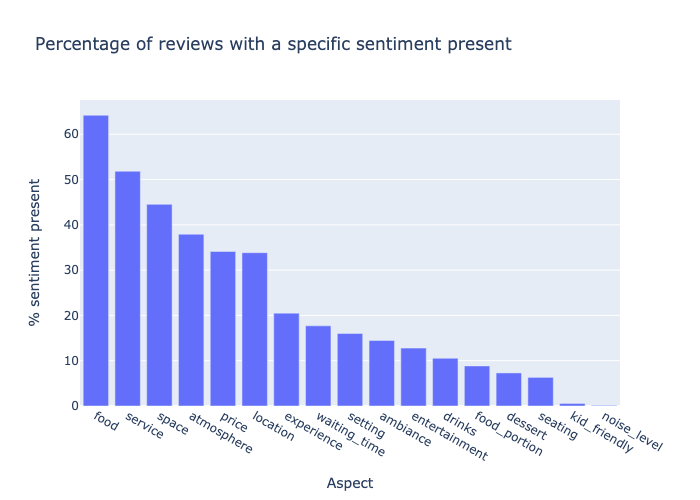

In [6]:
# Order the final data frame by descending order
deberta_eval_df = deberta_eval_df.sort_values(by=['% sentiment present'], ascending=False)

# Use the ordered dataframe to plot each aspect and % of reviews for which sentiment is present
fig = px.bar(deberta_eval_df, x='Aspect', y='% sentiment present', title = 'Percentage of reviews with a specific sentiment present')
fig.show("png")

### Visualization 2: Deberta results - Distribution of sentiments per aspect 

In [7]:
# Lookimg at the results above, majority of the aspects have mostly 'no mention' sentiment. 
# So, for our analysis, we are relying on the top 6 aspects

top_6_aspects = deberta_eval_df.head(6)['Aspect'].values

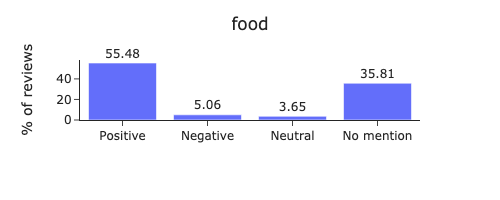

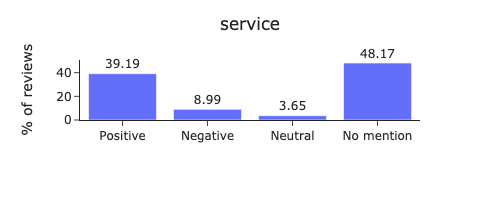

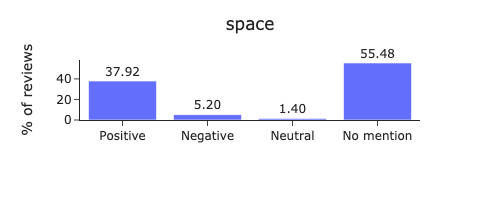

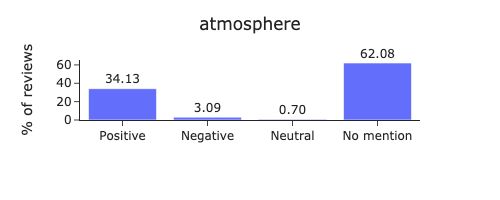

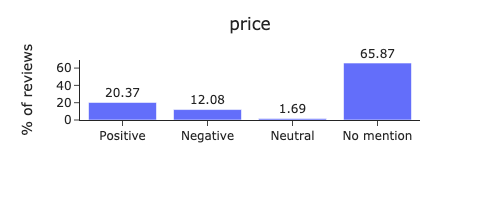

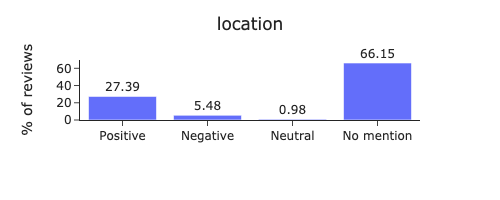

In [8]:
# Plot the histogram for each aspect of the sentiments 
for top_aspect in top_6_aspects:
    fig = px.histogram(deberta_viz_df, x = top_aspect+'_score', histnorm='percent', text_auto=True, width=500, height=200)
    fig.update_xaxes(categoryorder='array', categoryarray= ['Positive','Negative','Neutral','No mention'])
    fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False, texttemplate='%{y:.2f}')
    fig.update_layout(template='simple_white', yaxis_title='% of reviews', xaxis_title=None, title = top_aspect.split('_')[0], title_x=0.5)
    fig.show("png")

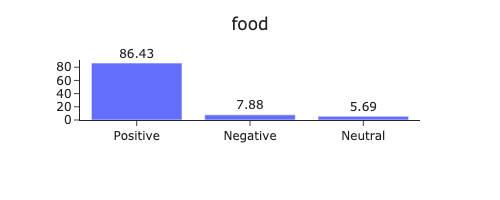

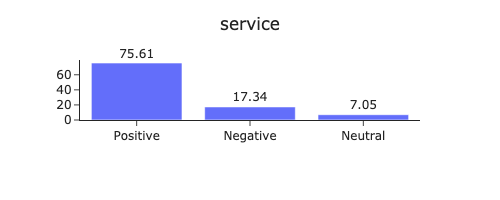

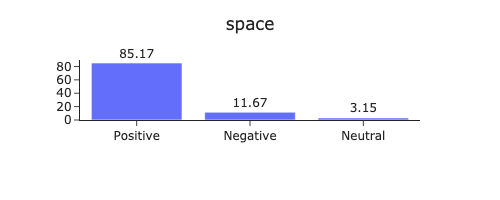

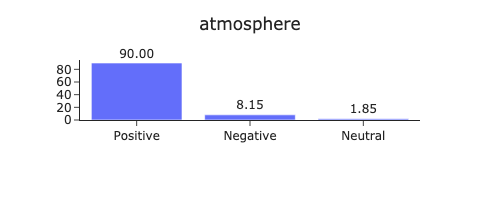

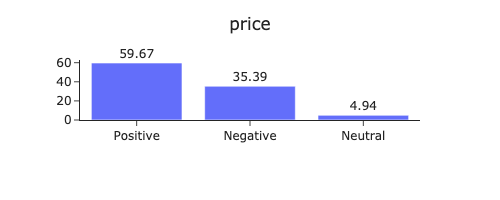

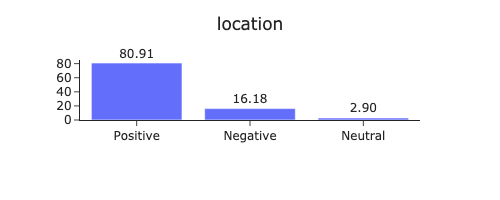

In [9]:
# Given that there is so many businesses with aspects that are categorized as "No mention" 
# we will remove this segment as well to look at the distribution for sentiments: positive, negative and neutral

for top_aspect in top_6_aspects:
    fig = px.histogram(deberta_viz_df[deberta_viz_df[top_aspect+ '_score']!='No mention'], x = top_aspect + '_score', histnorm='percent', text_auto=True, width=500, height=200)
    fig.update_xaxes(categoryorder='array', categoryarray= ['Positive','Negative','Neutral'])
    fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False, texttemplate='%{y:.2f}')
    fig.update_layout(template='simple_white', yaxis_title=None, xaxis_title=None, title = top_aspect.split('_')[0], title_x=0.5)
    fig.show("png")

### Visualization 3: Deberta results comparison with Restaurant owner provided sentiment for aspects- Aspect 

In [10]:
# Create the dataframe to compare results from Deberta model with that of the labels that the restaurant owner provided
comp_viz_rest_df = pd.DataFrame(np.array([\
                                            ['Price', len(deberta_viz_df[(deberta_viz_df['restaurant_is_expensive_owner_provided']=='Positive')]), 100.00*len(deberta_viz_df[(deberta_viz_df['price_score']=='Positive') & (deberta_viz_df['restaurant_is_expensive_owner_provided']=='Positive')])/\
                                                len(deberta_viz_df[deberta_viz_df['restaurant_is_expensive_owner_provided']=='Positive'])], \
                                            ['Good for kids', len(deberta_viz_df[(deberta_viz_df['good_for_kids_owner_provided']=='Positive')]), 100.00* len(deberta_viz_df[(deberta_viz_df['kid_friendly_score']=='Positive') & (deberta_viz_df['good_for_kids_owner_provided']=='Positive')])/\
                                                len(deberta_viz_df[deberta_viz_df['good_for_kids_owner_provided']=='Positive'])], \
                                ]),
                   columns=['Aspect', 'True Positive', 'Overall'])

In [11]:
# print the created dataframe
comp_viz_rest_df

,Aspect,True Positive,Overall
0,Price,53,20.754716981132077
1,Good for kids,439,0.683371298405467


In [12]:
# Convert the datatype of the columns to integer and float respectively

comp_viz_rest_df['True Positive'] = comp_viz_rest_df['True Positive'].astype('int')
comp_viz_rest_df['Overall'] = comp_viz_rest_df['Overall'].astype('float')

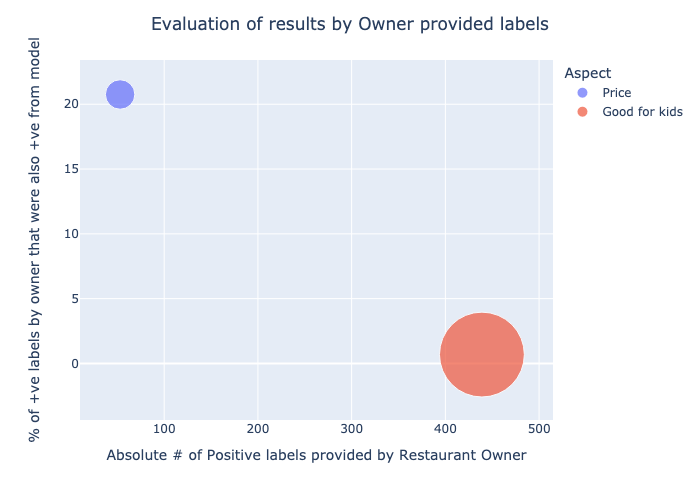

In [13]:
# Plot as scatter plot with size of the bubble represented by true positive absolute count
fig = px.scatter(comp_viz_rest_df, x="True Positive", y="Overall", size="True Positive", color="Aspect", size_max=60, width=700, height=500)
fig.update_layout(yaxis_title='% of +ve labels by owner that were also +ve from model', \
                  xaxis_title='Absolute # of Positive labels provided by Restaurant Owner',\
                  title = 'Evaluation of results by Owner provided labels', title_x=0.5)
fig.show("png")

### Visualization 4: Deberta results for each aspect

In [14]:
# for every aspect, trying to find the overall positive sentiment rate
cols = ['ambiance_score', 'atmosphere_score', 'dessert_score',\
       'drinks_score', 'entertainment_score', 'experience_score', 'food_score',\
       'food_portion_score', 'kid_friendly_score', 'location_score',\
       'price_score', 'seating_score', 'service_score', 'setting_score',\
       'space_score', 'waiting_time_score','noise_level_score']

viz_df = pd.DataFrame()

for col in cols:
    # find the positive rate
    pct_positive = len(deberta_viz_df[(deberta_viz_df[col]=='Positive')])/\
                    len(deberta_viz_df[(deberta_viz_df[col]=='Positive') | (deberta_viz_df[col]=='Negative') | (deberta_viz_df[col]=='Neutral')])
    
    total = len(deberta_viz_df[(deberta_viz_df[col]=='Positive') | (deberta_viz_df[col]=='Negative') | (deberta_viz_df[col]=='Neutral')])
    
    temp_viz_df = pd.DataFrame([[col.split('_score')[0], pct_positive, total]])
    
    viz_df = pd.concat([viz_df,temp_viz_df]) 

In [15]:
# create column names for the data frame
viz_df.columns = ['feature', 'pct_positive', 'total']

# sort the dataframe in descending order of # of businesses
viz_df = viz_df.sort_values(by=['total'], ascending=False)

features = viz_df.feature.values

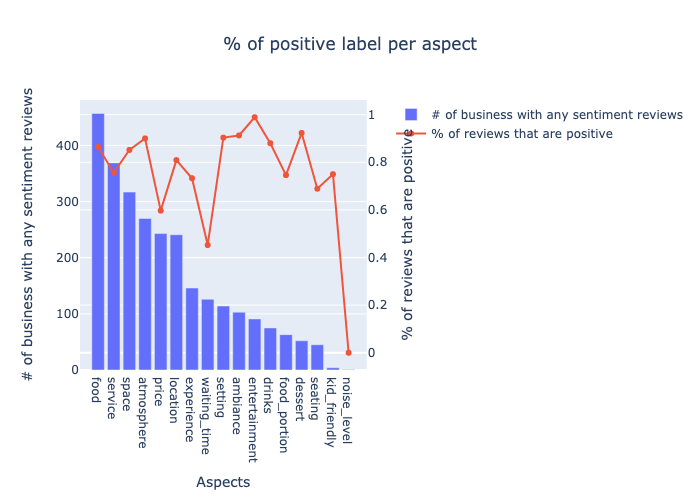

In [16]:
# Create the vix with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# add the bar chart
fig.add_trace(go.Bar(x=features, y=viz_df.total.values, name="# of business with any sentiment reviews"), secondary_y=False)

# add the line chart data points
fig.add_trace(go.Scatter(x=features, y=viz_df.pct_positive.values, name="% of reviews that are positive"), secondary_y=True)

# Add the title
fig.update_layout(title_text="% of positive label per aspect", title_x=0.5)

# Set x-axis title
fig.update_xaxes(title_text="Aspects")

# Set y-axes titles
fig.update_yaxes(title_text="# of business with any sentiment reviews", secondary_y=False)
fig.update_yaxes(title_text="% of reviews that are positive", secondary_y=True)

fig.show("png")

In [17]:
#done